# Práctico: Recomendación de Artistas

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [92]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import os
import nltk
import re
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gonza\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gonza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [93]:
os.getcwd()
os.chdir('C:\\Users\\gonza\\Google Drive\\Data Science\\Diplo Datos FAMAF\\SistemasDeRecomendacion\\practico')

In [94]:
artist_data = pd.read_csv("data/lastfm/artists.dat", sep="\t")
artist_data

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...
...,...,...,...,...
17627,18741,Diamanda Galás,http://www.last.fm/music/Diamanda+Gal%C3%A1s,http://userserve-ak.last.fm/serve/252/16352971...
17628,18742,Aya RL,http://www.last.fm/music/Aya+RL,http://userserve-ak.last.fm/serve/252/207445.jpg
17629,18743,Coptic Rain,http://www.last.fm/music/Coptic+Rain,http://userserve-ak.last.fm/serve/252/344868.jpg
17630,18744,Oz Alchemist,http://www.last.fm/music/Oz+Alchemist,http://userserve-ak.last.fm/serve/252/29297695...


In [95]:
## Creamos el diccionario de dos maneras, la segunda tiene mejor resultado
# artist_dict=artist_data[['id','name']].set_index('id').T.to_dict(orient='list')
artist_dict=dict(zip(artist_data['id'],artist_data['name']))

In [96]:
# 92834 user-listened artist relations, i.e. tuples [user, artist, listeningCount]
# weigth = Listening Count
user_artist_plays = pd.read_csv("data/lastfm/user_artists.dat", sep="\t")
user_artist_plays

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [97]:
tag_artist_data = pd.read_csv("data/lastfm/user_taggedartists.dat", sep="\t")
#tag_artist_data[tag_artist_data.userID==3].sort_values(by=['year','month'],ascending=True).head()
tag_artist_data

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009
...,...,...,...,...,...,...
186474,2100,16437,4,1,7,2010
186475,2100,16437,292,1,5,2010
186476,2100,16437,2087,1,7,2010
186477,2100,16437,2801,1,5,2010


In [98]:
tag_data = pd.read_csv("data/lastfm/tags.dat", sep="\t",  encoding='latin-1')
tag_data

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [99]:
#genres_dict=tag_data[['tagID','tagValue']].set_index('tagID').T.to_dict(orient='list')
genres_dict=dict(zip(tag_data['tagID'],tag_data['tagValue']))

In [100]:
friend_data = pd.read_csv("data/lastfm/user_friends.dat", sep="\t",  encoding='latin-1')
friend_data

,userID,friendID
0,2,275
1,2,428
2,2,515
3,2,761
4,2,831
...,...,...
25429,2099,1801
25430,2099,2006
25431,2099,2016
25432,2100,586


In [101]:
user_time=pd.read_csv("data/lastfm/user_taggedartists-timestamps.dat", sep="\t",  encoding='latin-1')

## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando (quienes estén realizando la materia completa, en realidad pueden realizar ambas opciones si así lo desean).

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [102]:
# Vemos los 100 artistas más populares (escuchados por diferentes personas)
artist_pop=user_artist_plays.groupby('artistID').count().sort_values(by=['userID'],ascending=False).reset_index().iloc[0:100,]

In [103]:
# Usar un diccionario para tener la columna nombre de artista.
artist_pop['name']=artist_pop['artistID'].map(artist_dict)
artist_pop

,artistID,userID,weight,name
0,89,611,611,Lady Gaga
1,289,522,522,Britney Spears
2,288,484,484,Rihanna
3,227,480,480,The Beatles
4,300,473,473,Katy Perry
...,...,...,...,...
95,680,126,126,The Veronicas
96,523,125,125,Lindsay Lohan
97,225,125,125,Interpol
98,436,124,124,The Smashing Pumpkins


In [104]:
# Vemos los 100 artistas con más reproducciones

user_artist_plays.groupby('artistID')['weight'].sum().sort_values(ascending=False).reset_index().iloc[0:100,]
# Para visualizar por nombres, descomentar la linea siguiente.
#user_artist_plays.groupby('artistID')['weight'].sum().sort_values(ascending=False).reset_index().iloc[0:100,]['artistID'].map(artist_dict)

,artistID,weight
0,289,2393140
1,72,1301308
2,89,1291387
3,292,1058405
4,498,963449
...,...,...
95,868,95880
96,889,94551
97,331,94501
98,1048,94398


In [105]:
rep_curve=user_artist_plays.groupby('artistID')['weight'].sum().sort_values(ascending=True).reset_index()

<AxesSubplot:xlabel='weight', ylabel='Probability'>

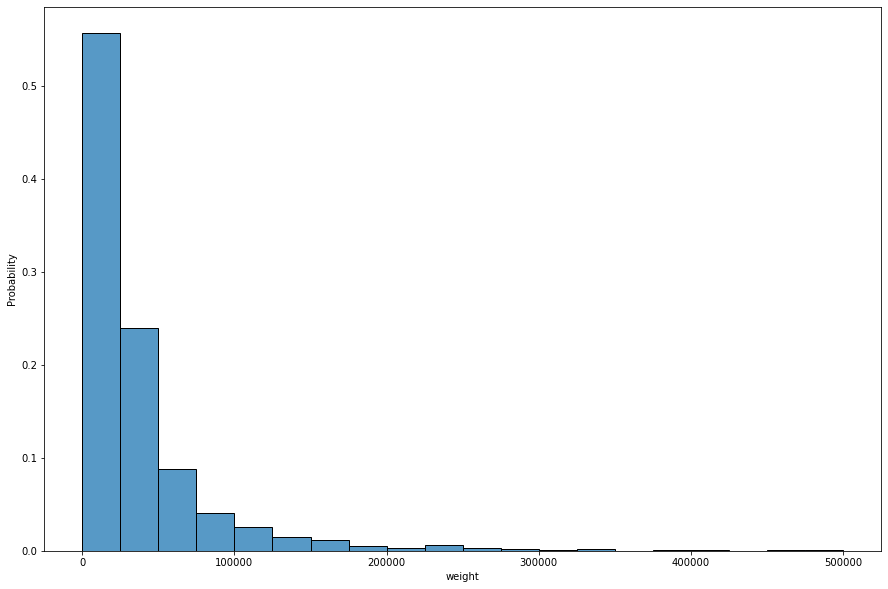

In [106]:
# Vemos la cantidad de reproducciones por usuario
user_rep=user_artist_plays.groupby(['userID'])['weight'].sum().reset_index()
plt.figure(figsize=(15,10))
sns.histplot(user_rep, x='weight',  binwidth=25000, stat='probability')

In [107]:
# Cuantos amigos tiene cada usuario?
friend_q=friend_data.groupby('userID').count()
friend_q.describe()

,friendID
count,1892.000000
mean,13.442918
std,17.312489
min,1.000000
25%,3.000000
50%,6.000000
75%,17.000000
max,119.000000


<AxesSubplot:xlabel='friendID', ylabel='Probability'>

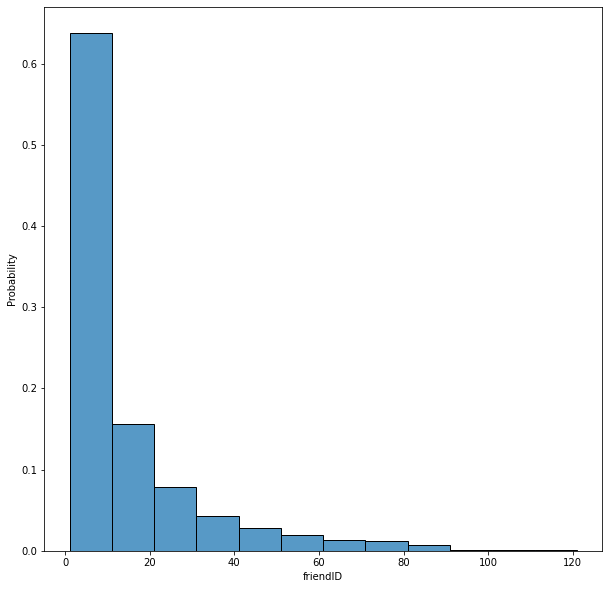

In [108]:
# Graficamos un histograma para ver distribución de cantidad de amigos.
plt.figure(figsize=(10,10))
sns.histplot(friend_q, x='friendID',  binwidth=10, stat='probability')

In [109]:
# Cuales son los generos mas escuchados?
pop_genres=tag_artist_data.groupby('tagID')['userID'].count().sort_values(ascending=False).reset_index().iloc[0:100,]
pop_genres.columns=['tagID','count']
pop_genres['genres_name']=pop_genres['tagID'].map(genres_dict)
pop_genres

,tagID,count,genres_name
0,73,7503,rock
1,24,5418,pop
2,79,5251,alternative
3,18,4672,electronic
4,81,4458,indie
...,...,...,...
95,228,335,catchy
96,378,334,deathcore
97,541,331,japanese
98,17,327,synth pop


## Ejercicio 2 - Sistema de Recomendación

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para quienes quieran aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa pueden optar por saltearse este ejercicio (aunque es recomendable pensarlo) y pasar directamente al [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

### Desarrollo de la matriz de Usuario-Contenido

In [110]:
# Importamos las librerías para leer los datos como los necesita suprise
from surprise import Dataset, Reader

In [111]:
user_artist_plays

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


In [112]:
# Armamos el DF que usaremos
user_rating=user_artist_plays

# Calculamos el maximo peso.
weight_max=user_rating['weight'].max()

# Ponemos todo en función del maximo valor
user_rating['weight']= user_rating['weight']/(weight_max)

# Así cambiamos el nombre de la columna weight por rating
user_rating=user_rating.rename({'weight':'rating'}, axis='columns')


Desarrollo de la matriz de Usuario-Contenido utilizando el codigo de
https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb

In [113]:
# Podemos convertir el sparse array de scipy en un sparse df con pd.DataFrame.sparse.from_spmatrix

from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (userId, ItemId, rating)
    
    Returns:
        X: sparse matrix - User-content matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """
    M = df['userID'].nunique() #cuenta la cantidad de valores unicos que hay entre los usuarios
    N = df['artistID'].nunique() #cuenta la cantidad de valores unicos que hay entre los items

    user_mapper = dict(zip(np.unique(df["userID"]), list(range(M)))) #crea un diccionario para vincular cada valor de
    #usuario con un valor de una lista. Ej: El usuario 2 es el 0 de la lista
    
    art_mapper = dict(zip(np.unique(df["artistID"]), list(range(N)))) #crea un diccionario para vincular cada valor de
    #item con un valor de una lista.
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userID"]))) # Es la inversa de lo anterior. Según el valor de
    #la lista, tenemos cual es el usuario al que corresponde.
    art_inv_mapper = dict(zip(list(range(N)), np.unique(df["artistID"])))# Es la inversa de lo anterior. Según el valor de
    #la lista, tenemos cual es el item al que corresponde.
    
    user_index = [user_mapper[i] for i in df['userID']] # con el diccionario le asignamos a cada observación de usuario
    #su posición en la lista. Como los usuarios evaluan muchos items, tenemos valores repetidos en las filas.
    art_index = [art_mapper[i] for i in df['artistID']] # idem anterior pero con items

    #X = pd.DataFrame.sparse.from_spmatrix(csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N)))
    X = csr_matrix((df["rating"], (user_index,art_index)), shape=(M,N)) #toma los valores de la columna rating y los asigna
    # según el indice que le corresponde a cada usuario y a cada artista.
    return X, user_mapper, art_mapper, user_inv_mapper, art_inv_mapper

# Para poder recuperar los datos exactos de puntaje por artista y usuario tengo que
# aplicar los diccionarios "inv_mapper" sobre las filas (usuarios) y colunmas (artistas) de la matriz.
# Si además deseo recuperar los nombres de los artistas, además tengo que usar el diccionario artist_dict
# que me vincula artistID con el nombre del artista.

X, user_mapper, art_mapper, user_inv_mapper, art_inv_mapper = create_X(user_rating)

In [114]:
from scipy.sparse import csr_matrix
def get_user_item_sparse_matrix(df):
    sparse_data = csr_matrix((df.rating, (df.userID, df.artistID)))
    return sparse_data
Y=get_user_item_sparse_matrix(user_rating)

In [115]:
# calculamos la matriz de similaridad (vemos diferentes opciones)

# Similaridad Coseno:
from sklearn.metrics.pairwise import cosine_similarity
sim_coseno=cosine_similarity(X,X)

# Similaridad euclidea
from sklearn.metrics.pairwise import euclidean_distances
sim_euclidea=euclidean_distances(X,X)

# Similaridad Manhattan
from sklearn.metrics.pairwise import manhattan_distances
sim_manhattan=manhattan_distances(X,X)

### Entrenamiento de algoritmos de recomendación

#### Pasos preliminares

In [116]:
# Cargamos los datos en el reader para surprise
reader=Reader(rating_scale=((user_rating.rating.min(), user_rating.rating.max())))
data=Dataset.load_from_df(user_rating,reader)

# Hacemos la divisón entre train y test y definimos la metrica (RMSE)
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate, train_test_split
ratings_train, ratings_test = train_test_split(data, test_size=0.3)

#### Entrenamiento de algoritmos

Modelo 1: KNN Basico

In [117]:
from surprise import KNNBaseline

# Tenemos que definir los aspectos de la matriz de similaridad.
sim_options={'name': 'cosine', 'user_based': False}
# 'name': 'pearson', 'cosine', 'msd', 'pearson_baseline' (esto es que tipo de similaridad usaremos)
# user_based: 'True', 'False' Define si va a ser con similaridad por usuario (True) o por contenido (False)

# En este caso lo vamos a hacer basado en contenido para que en el paso siguiente nos sirva el modelo estimado.

model_knn = KNNBaseline(k=5, sim_options=sim_options).fit(ratings_train)
predictions_knn = model_knn.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions_knn, verbose=False)))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0118


Modelo 2: KNN With Means
Este modelo intenta quitar el sesgo de cada item al quitarle la media a cada item/usuario

In [118]:
from surprise import KNNWithMeans
model_km = KNNWithMeans(k=40, sim_options=sim_options).fit(ratings_train)
predictions_km = model_km.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions_km, verbose=False)))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0117


Modelo 3: KNN With ZScore
En este modelo tratamos de corregir los valores extremos que tenemos

In [119]:
from surprise import KNNWithZScore
model_kz = KNNWithZScore(k=10, sim_options=sim_options).fit(ratings_train)
predictions_kz = model_kz.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions_kz, verbose=False)))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE on test: 0.0119


Modelo 4: Co-clustering
Aca se crean clusters de usuarios, de contenido y de usuarios y contenio, y se estima en función de los ratings de esos clusters

In [120]:
from surprise import CoClustering

model_cc = CoClustering().fit(ratings_train)
predictions_cc = model_cc.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions_cc, verbose=False)))

RMSE on test: 0.0115


#### Conclusiones

Utilizando surprise el mejor resultado observado ha sido utilizando CoClustering, de la familia de vecinos cercanos los mejores puntajes se obtuvieron con KNNWithZScore

### Entrenamiento sistema de recomendación

In [121]:
# Tomamos algunos códigos de artistas (artistID) para ver quienes serían sus similares
artist_pop.head(5) 

,artistID,userID,weight,name
0,89,611,611,Lady Gaga
1,289,522,522,Britney Spears
2,288,484,484,Rihanna
3,227,480,480,The Beatles
4,300,473,473,Katy Perry


En la sección anterior vimos que el mejor modelo era KNN With Zscore, por lo que lo utilizaremos para buscar los items similares

In [122]:
id_artist=288 # Código de artista que nos interesa
q_sim=10 # Cantidad de items similares que deseamos

# Tenemos que pasar nuestro código de artista a la forma en que los tiene codificados el modelo en surprise
art_id=model_kz.trainset.to_inner_iid(id_artist)

# Con este código de artista buscamos los vecinos cercanos (en codigos internos -inner_id)
sim_artist_inner=model_kz.get_neighbors(art_id,q_sim)

# Hacemos la conversion de codigos internos a externos de artistas similares
sim_artist = (model_kz.trainset.to_raw_iid(inner_id) for inner_id in sim_artist_inner)

print(f"Buscar los {q_sim} más similares a {artist_dict[id_artist]}")
for i in sim_artist:
    print(artist_dict[i])

Buscar los 10 más similares a Rihanna
Alan Jackson
Low
P.O.D.
Alkaline Trio
The Dresden Dolls
Globus
lynch.
Jimi Hendrix
Darko Rundek
Javier Navarrete


In [123]:
# Devuelve artistas sin sentido.

#### Desarrollo alternativo para tener los items similares

In [124]:
n_ratings_per_movie = X.getnnz(axis=0) # numero de rantings que tiene cada pelicula
sum_ratings_per_movie = X.sum(axis=0) # suma de los ratings que tiene cada pelicula
mean_rating_per_movie = sum_ratings_per_movie/n_ratings_per_movie # promedio de ratings por pelicula
X_mean_movie = np.tile(mean_rating_per_movie, (X.shape[0],1)) # creamos una matriz con la media de las peliculas
# repetimos las medias de las peliculas para cada usuario (1892)
X_norm = X - csr_matrix(X_mean_movie) # eliminamos el sesgo de item de la matriz de similitud. Los items que no tenian
# puntaje para cada 

In [125]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    
    X = X.T # trasponemos para poder tener los items como FILAS (estaban como columnas)
    neighbour_ids = [] # arreglo vacio para luego completarlo
    
    movie_ind = movie_mapper[movie_id] # hacemos el mapeo para saber cual es la columna que necesitamos
    movie_vec = X[movie_ind] # nos quedamos solo con la fila de esa pelicula
    if isinstance(movie_vec, (np.ndarray)): # con esta comprobamos que sea un array
        movie_vec = movie_vec.reshape(1,-1) # lo convertimos en un vector fila, por si no lo es.
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric) # función para encontrar los vecinos cercanos
    kNN.fit(X) # Aplicamos la función a X para tener computados los vecinos cercanos de X
    neighbour = kNN.kneighbors(movie_vec, return_distance=False) # buscamos los vecinos cercanos a ese vector de puntajes
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors
    
    #for i in range(0,k+1): #modificamos esto para no generar una busqueda de vecinos que luego tiramos (el 0)
    for i in range(1,k+1): # armamos un bucle for para encontrar los K primeros vecinos cercanos
        n = neighbour.item(i) # Encontramos el codigo interno del vecino i
        neighbour_ids.append(movie_inv_mapper[n])  # Agregamos la inversa de ese codigo al listado
    #neighbour_ids.pop(0) # tiramos el elemento cero.
    return neighbour_ids
# No sería igual y mas eficiente si lo hacemos al bucle de i que va de 1 a K

In [126]:
# Nos busca los artistas más similares según los puntajes de los usuarios.

art_id=288
similar_movies=find_similar_movies(art_id, X, art_mapper, art_inv_mapper, 10, metric='cosine')

movie_title = artist_dict[art_id]

print(f"Because you listened {movie_title}:")
for i in similar_movies:
    print(artist_dict[i])

Because you listened Rihanna:
Black Eyed Peas
Ke$ha
Jordin Sparks
Jay-Z, Bono, The Edge & Rihanna
Haley James Scott
Jessie J
Beyoncé
Panic at the Disco
Katy Perry
Willow


### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.

### Evaluación sobre cold-start

In [127]:
# Se eliminarán de la base los siguientes artistas (están dentro de los 100 más populares)
# 300 Katy Perry
# 288 Rihanna
# 436 The Smashing Pumpkins

### Vectores de contenido

In [128]:
# Comenzamos a trabajar sobre el archivo de tags de los usuarios

# Primero tenemos que pasar los tag a minusculas
tag_data = pd.read_csv("data/lastfm/tags.dat", sep="\t",  encoding='latin-1')
tag_data['tagValue']=tag_data['tagValue'].str.lower()

# Usamos expresiones regulares para poder simplificar el análisis semántico.
# Para poder usar las regex tenemos que usar las lambda functions para aplicar de manera iterativa.

tag_data['tagValue']=tag_data.tagValue.map(lambda x: re.sub(r'\W/g',repl='',string=x))
tag_data

,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal
...,...,...
11941,12644,suomi
11942,12645,symbiosis
11943,12646,sverige
11944,12647,eire


In [129]:
stop_words = set(stopwords.words(['english','spanish']))

# Generamos los tags como listas según sus componentes (ejemplo: dark metal es [dark, metal])
tag_data['tagValue']=tag_data.apply(lambda x: nltk.word_tokenize(x['tagValue']), axis=1)

# Limpiamos las stop words
tag_data['tagValue']=tag_data['tagValue'].map(lambda x: list(x for x in x if not x in stop_words))

In [130]:
# Armamos un diccionario con la frecuencia de las palabras del archivo de tags
tagfreq = {}
for tag in tag_data.tagValue:
    tokens =tag
    for token in tokens:
        if token not in tagfreq.keys():
            tagfreq[token] = 1
        else:
            tagfreq[token] += 1

In [131]:
# Ordenamos para tener las palabras más frecuentes
tagfreq=sorted(tagfreq.items(), key=lambda x: x[1], reverse=True)

In [132]:
pd.DataFrame.from_dict(tagfreq)

,0,1
0,rock,391
1,metal,324
2,music,247
3,pop,233
4,songs,168
...,...,...
9407,pilgrim,1
9408,suomi,1
9409,symbiosis,1
9410,sverige,1


In [133]:
tag_dict=dict(zip(tag_data['tagID'],tag_data['tagValue']))

In [134]:
# Eliminamos columnas que no son de utilidad
tag_artist=tag_artist_data.drop(['userID','day', 'month', 'year'], axis=1)

# Agrupamos artistas y creamos listas con sus tag.
# Esto lo hacemos ahora porque como están con los ID (tanto los artistas como los tag) ocupan menos espacio en memoria
tag_artist=tag_artist.groupby("artistID").agg(list).reset_index()

# Aplicamos un dic para poder ir convirtiendo los codigos en palabras.
tag_artist['artista']=tag_artist['artistID'].map(artist_dict)

# En el caso de los ID lo hacemos diferente porque tenemos una lista dentro de cada observacion
tag_artist['tag']=tag_artist['tagID'].map(lambda x: list(map(tag_dict.get, x)))

# Lo anterior nos generó una "lista de listas", ya que teniamos las listas de tokens y las metimos dentro de otras listas
# para solucionar eso usamos lo siguiente
tag_artist['tag']=tag_artist['tag'].map(lambda x: list(x for sublist in x for x in sublist))

# Eliminamos columnas que ya no sirven
#tag_artist=tag_artist.drop(['artistID'], axis=1)
tag_artist=tag_artist.drop(['tagID'], axis=1)
tag_artist.head()

,artistID,artista,tag
0,1,MALICE MIZER,"[weeabo, jrock, j-rock, visual, kei, better, l..."
1,2,Diary of Dreams,"[german, seen, live, darkwave, industrial, ger..."
2,3,Carpathian Forest,"[black, metal, black, metal, norwegian, black,..."
3,4,Moi dix Mois,"[j-rock, visual, kei, metal, gothic, japanese,..."
4,5,Bella Morte,"[gothic, gothic, rock, darkwave, darkwave, dea..."


In [135]:
# Creamos el diccionario para tener frecuencia de palabras
tag_art_freq = {}
for tag in tag_artist.tag:
    tokens = tag # aca lo hacemos directo porque ya tenemos tokenizados los generos
    for token in tokens:
        if token not in tag_art_freq.keys():
            tag_art_freq[token] = 1
        else:
            tag_art_freq[token] += 1

# Ordenamos el diccionario
tag_art_freq=sorted(tag_art_freq.items(), key=lambda x: x[1], reverse=True)
#tag_art_freq

In [136]:
# Visualizamos la canitdad de tags que tenemos
len(tag_art_freq)

7796

In [137]:
# Creamos un Df para poder manipular mejor los datos
tag_art_freq_df=pd.DataFrame.from_dict(tag_art_freq)
tag_art_freq_df.columns=('tag', 'freq')
tag_art_freq_df

,tag,freq
0,rock,23041
1,pop,9517
2,metal,9250
3,alternative,8242
4,indie,7602
...,...,...
7791,net,1
7792,ou,1
7793,avantgrade,1
7794,ustad,1


In [138]:
# Dada la cantidad de datos que tenemos, disminuimos la cantidad de tags por cuestiones de memoria (no puedo generar
# el one hot enconder)

# Cual debería ser la frecuencia acumulada mínima para que lo consideremos? Una alternativa es el 80%.
# Lo que está por debajo de ese valor podría ser analizado posteiormente para encontrar algún "nicho" en esos usuarios

minimo=0.8

cota=round(tag_art_freq_df.freq.sum()*minimo)

print("Se debe incorporar tags hasta alcanzar una frecuencia acumulada de",cota,'equivalente al',minimo*100,'% del total')

Se debe incorporar tags hasta alcanzar una frecuencia acumulada de 205462 equivalente al 80.0 % del total


In [139]:
# Ordenamos por frecuencia cada tag
tag_art_freq_df=tag_art_freq_df.sort_values(by='freq', ascending=False)

# Calculamos la frecuencia acumulada
tag_art_freq_df['cum']=tag_art_freq_df.freq.cumsum()/tag_art_freq_df.freq.sum()

# Aplicamos la cota para poder limitar la cantidad de columnas
tag_art_freq_df=tag_art_freq_df[tag_art_freq_df.cum<=minimo]

# Creamos la lista de tags 'admitidos' ¿Es una lista o un set lo mejor?
# Mejor set porque es mas eficiente
admitidos = set(tag_art_freq_df.tag)
#admitidos = list(tag_art_freq_df.tag)
print('Nos quedamos con',len(admitidos),'tags')

Nos quedamos con 267 tags


In [140]:
# Limpiamos los tags no admitidos según nuestro criterio
tag_artist['tag']=tag_artist['tag'].map(lambda x: list(set(x) & set(admitidos)))
tag_artist

,artistID,artista,tag
0,1,MALICE MIZER,"[japanese, visual, kei, gothic, better, j-rock]"
1,2,Diary of Dreams,"[dark, vocal, seen, ambient, electronic, germa..."
2,3,Carpathian Forest,"[black, metal, norwegian]"
3,4,Moi dix Mois,"[japanese, visual, rock, kei, gothic, metal, j..."
4,5,Bella Morte,"[covers, darkwave, gothic, rock]"
...,...,...,...
12518,18737,Ciccone Youth,"[electronica, 80s, noise, alternative]"
12519,18739,Apollo 440,"[favorite, electronica, electronic, rock, alte..."
12520,18740,Die Krupps,"[ebm, industrial]"
12521,18741,Diamanda Galás,"[music, experimental]"


In [142]:
contenido=tag_artist.copy()

In [143]:
# Vemos que disminuyeron muchos tags. Quedaron artistas sin tags?
# Quedaron sin tag 639 registros, pero muchos de esos ya tienenalgún otro tag (dentro del 80%)
art_tag_borrados=tag_artist[tag_artist["tag"].str.len() == 0]

art_tag_borrados.artista.value_counts()
# Con estos artistas podemos hacer alguna incorporación agregando los tags que más los representan (el 80% de ese 20%)

Blasted Mechanism             1
Gül Erda                      1
Olallo Rubio                  1
The Joystick                  1
Billy Bragg and The Blokes    1
                             ..
Batlik                        1
Yoñlu                         1
Icon & the Black Roses        1
Gusttavo Lima                 1
Billy Connolly                1
Name: artista, Length: 639, dtype: int64

In [144]:
for t in admitidos:
    contenido[t] = contenido.tag.transform(lambda x: int(t in x))
contenido

,artistID,artista,tag,japanese,technical,post-punk,jazz,polish,soft,nu,...,idm,symphonic,psytrance,post-grunge,shit,stoner,synthpop,90s,country,post-rock
0,1,MALICE MIZER,"[japanese, visual, kei, gothic, better, j-rock]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Diary of Dreams,"[dark, vocal, seen, ambient, electronic, germa...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Carpathian Forest,"[black, metal, norwegian]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Moi dix Mois,"[japanese, visual, rock, kei, gothic, metal, j...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Bella Morte,"[covers, darkwave, gothic, rock]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12518,18737,Ciccone Youth,"[electronica, 80s, noise, alternative]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12519,18739,Apollo 440,"[favorite, electronica, electronic, rock, alte...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12520,18740,Die Krupps,"[ebm, industrial]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12521,18741,Diamanda Galás,"[music, experimental]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [145]:
# Eliminamos columnas que no necesitamos (tags con nombres)
contenido=contenido.drop('tag', axis=1)

# Reseteamos el indice para evitar cualquier problema que podemos tener de continuidad
contenido=contenido.reset_index()

# Creamos un diccionario que nos permita a partir del valor del índice (que recien reseteamos) saber cual era el artista
dict_inart=dict(zip(list(contenido.index),contenido['artista']))

# Elimamos el artista
contenido=contenido.drop(['artista','index'], axis=1)
contenido

,artistID,japanese,technical,post-punk,jazz,polish,soft,nu,good,one,...,idm,symphonic,psytrance,post-grunge,shit,stoner,synthpop,90s,country,post-rock
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12518,18737,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12519,18739,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12520,18740,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12521,18741,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Sistema de recomendación

Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.

In [54]:
# Tenemos que crear un sistema hibrido que combine la similaridad de los tags (recomendación basada en contenido) y la
# similaridad de los usuarios (recomendación colaborativa)
# Como menciona, la función tendría que ser algo que me permita ingresar el nombre del artista, me busque los tags que tiene
# cargados y que me haga la recomendación.
# Que hacer cuando el artista no está en la base?
# Podriamos poner un paso de decision que sea si quiere colaborar y ingresar 2/3 tags, y usamos el sistema de contenido, o
# le devolvemos el top "n" de artistas ordenados según los tags mas populares.

In [55]:
# Con la matriz anterior tenemos que calcular las similaridades de los artistas frente a diferentes tags.

In [146]:
T=tag_artist.copy()

In [57]:
from sklearn.metrics.pairwise import cosine_similarity
sim_coseno=cosine_similarity(T,T)

# Similaridad euclidea
from sklearn.metrics.pairwise import euclidean_distances
sim_euclidea=euclidean_distances(T,T)

# Similaridad Manhattan
from sklearn.metrics.pairwise import manhattan_distances
sim_manhattan=manhattan_distances(T,T)

In [58]:
sim_coseno

array([[1.        , 0.27500955, 0.32732684, ..., 0.37796447, 0.37796447,
        0.37796447],
       [0.27500955, 1.        , 0.42008403, ..., 0.48508419, 0.48507125,
        0.48509712],
       [0.32732684, 0.42008403, 1.        , ..., 0.8660254 , 0.8660254 ,
        0.86602539],
       ...,
       [0.37796447, 0.48508419, 0.8660254 , ..., 1.        , 0.99999999,
        0.99999998],
       [0.37796447, 0.48507125, 0.8660254 , ..., 0.99999999, 1.        ,
        0.99999998],
       [0.37796447, 0.48509712, 0.86602539, ..., 0.99999998, 0.99999998,
        1.        ]])

In [163]:
# Para usar el algoritmo modificamos los nombres de los atributos
user_rating.columns=["userID","movieId" ,"rating"]
artistas=tag_artist.copy()
artistas.columns=["movieId","title","genres"]

In [150]:
# Tenemos que eliminar a los artistas elegidos de los DF a utilizar.
# 300 Katy Perry
# 288 Rihanna
# 436 The Smashing Pumpkins
cold = [300, 288, 436]

# los eliminamos del DF con los tags
artistas = artistas[~artistas.movieId.isin(cold)]

# los eliminamos del DF de puntajes
user_rating = user_rating[~user_rating.movieId.isin(cold)]

# Verificamos que no aparezcan
user_rating[user_rating.movieId==300]
artistas[artistas.movieId==300]

,movieId,title,genres


In [165]:
# Configuramos el suprise nuevamente.
reader=Reader(rating_scale=((user_rating.rating.min(), user_rating.rating.max())))
data=Dataset.load_from_df(user_rating,reader)

# Hacemos la divisón entre train y test y definimos la metrica (RMSE)
from surprise.accuracy import rmse, mae
from surprise.model_selection import cross_validate, train_test_split
ratings_train, ratings_test = train_test_split(data, test_size=0.3)

In [166]:
# Definimos el modelo que mejor resultados presento en el punto anterior.
cf_model = KNNWithZScore(k=5, sim_options={"user_based": False, "name": "cosine"}).fit(ratings_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [167]:
# Creamos un sistema basado en contenido
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

class GenresBasedFilter(object):
    def __init__(self, movies, k=5):
        self.movie_to_idx = {row["movieId"]: idx for idx, row in movies.iterrows()}
        self.idx_to_movie = {idx: movie for movie, idx in self.movie_to_idx.items()}
        self.k = k

        genres = set(g for G in movies['genres'] for g in G)
        for g in genres:
            movies[g] = movies.genres.transform(lambda x: int(g in x))

        self.movie_genres = movies.drop(columns=['movieId', 'title', 'genres'])

    def fit(self, ratings):
        self.movies_cosine_sim_ = cosine_similarity(self.movie_genres, self.movie_genres)

        self.user_ratings_ = {}
        for (user_id, movie_id, rating) in ratings.build_testset():
            if user_id not in self.user_ratings_:
                self.user_ratings_[user_id] = {}
            self.user_ratings_[user_id][movie_id] = rating

        return self

    def predict(self, user, movie):
        if not user in self.user_ratings_ or not movie in self.movie_to_idx:
            global_mean = np.mean([
                rating for movies in self.user_ratings_.values() for rating in movies.values()
            ])
            return global_mean

        movie_idx = self.movie_to_idx[movie]
        sim_scores = list(enumerate(self.movies_cosine_sim_[movie_idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:]

        sims = []

        for movie, score in sim_scores:
            if self.idx_to_movie[movie] in self.user_ratings_[user]:
                sims.append((self.user_ratings_[user][self.idx_to_movie[movie]], score))
                if len(sims) >= self.k:
                    break

        user_mean = np.mean(list(self.user_ratings_[user].values()))

        pred = 0
        sim_sum = 0

        for rating, score in sims:
            pred += score * (rating - user_mean)
            sim_sum += score

        if sim_sum == 0:
            return user_mean

        return user_mean + pred / sim_sum

In [168]:
# Estimamos el modelo de filtrado basado en contenido
cb_model = GenresBasedFilter(artistas).fit(ratings_train)

Creamos el FWLS

In [169]:
# Paso 1: Creamos las estimaciones de puntaje por pelicula y usuario.
from tqdm.notebook import tqdm

transformed_ratings_train = []

for u, m, r in tqdm(ratings_train.build_testset()):
    transformed_ratings_train.append({
        "userID": u,
        "movieId": m,
        "cb_rating": cb_model.predict(u, m),
        "cf_rating": cf_model.predict(u, m).est,
        "rating": r
    })

transformed_ratings_train = pd.DataFrame(transformed_ratings_train)

  0%|          | 0/64227 [00:00<?, ?it/s]

In [170]:
# Paso 2: Definimos las funciones atributo
from collections import defaultdict

# Creamos la media de rating de cada usuario
user_mean_rating = defaultdict(
    lambda: transformed_ratings_train["rating"].mean(),
    transformed_ratings_train.groupby("userID")["rating"].mean().to_dict()
)
# Contamos la cantidad de veces que un usuario evaluo algo.
user_num_rating = defaultdict(
    lambda: 0,
    transformed_ratings_train.groupby("userID").size().to_dict()
)

# Primer atributo: Una ordenada al origen
def feature_function_constant():
    return 1

# Segundo atributo: La media de rating por usuario.
def feature_function_mean(user_id):
    return user_mean_rating[user_id]
# Tercer atributo: Cantidad de evaluaciones
def feature_function_over(user_id, min_ratings=3):
    return int(user_num_rating[user_id] >= min_ratings)

In [171]:
# Paso 3: Generamos los atributos de entrenamiento
for base_model in ["cb", "cf"]:
    transformed_ratings_train["{}_rating_fc".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_train["{}_rating_fm".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_train["{}_rating_fo".format(base_model)] =\
        transformed_ratings_train.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over(row["userID"]),
            axis=1
        )

In [172]:
# Paso 4: Entrenamos el modelo
from sklearn.linear_model import LinearRegression

fwls_model = LinearRegression()

feature_cols = ["{}_rating_{}".format(fm, ff) for fm in ["cb", "cf"] for ff in ["fc", "fo", "fm"]]

fwls_model.fit(
    transformed_ratings_train[feature_cols],
    transformed_ratings_train["rating"]
)

LinearRegression()

In [173]:
# Paso 5: Evaluamos el modelo.
# A - Cargamos los datos con el conjunto de test.
transformed_ratings_test = []

for u, m, r in tqdm(ratings_test):
    transformed_ratings_test.append({
        "userID": u,
        "movieId": m,
        "cb_rating": cb_model.predict(u, m),
        "cf_rating": cf_model.predict(u, m).est,
        "rating": r
    })

transformed_ratings_test = pd.DataFrame(transformed_ratings_test)

  0%|          | 0/27526 [00:00<?, ?it/s]

In [174]:
# Paso 5: Evaluamos el modelo.
# B - Estimamos el FWLS
for base_model in ["cb", "cf"]:
    transformed_ratings_test["{}_rating_fc".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_constant(),
            axis=1
        )
    transformed_ratings_test["{}_rating_fm".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_mean(row["userID"]),
            axis=1
        )
    transformed_ratings_test["{}_rating_fo".format(base_model)] =\
        transformed_ratings_test.apply(
            lambda row: row["{}_rating".format(base_model)] * feature_function_over(row["userID"]),
            axis=1
        )

transformed_ratings_test["fwls_rating"] = fwls_model.predict(transformed_ratings_test[feature_cols])

In [175]:
# Paso 6: Comparamos las métricas de evaluación para ver que modelo es mejor.
from sklearn.metrics import mean_squared_error

for model in ["cf", "cb", "fwls"]:
    rmse = np.sqrt(
        mean_squared_error(
            transformed_ratings_test["rating"],
            transformed_ratings_test["{}_rating".format(model)]
        )
    )
    
    print("RMSE for {} model: {:03f}".format(model, rmse))

RMSE for cf model: 0.011735
RMSE for cb model: 0.012169
RMSE for fwls model: 0.011390


In [ ]:
# El modelo con menor error es el de filtrado colaborativo. El FWLS es mejor que el basado en contenído.

In [179]:
# avg ratings and rating counts
avg_rating = transformed_ratings_test.groupby("movieId")["fwls_rating"].mean()
num_ratings = transformed_ratings_test.groupby("movieId")["fwls_rating"].count()
# getting counts and average ratings
fwls_ratings_counts = pd.DataFrame({"avg_rating": avg_rating,
                               "num_of_ratings": num_ratings})
# joining the new values to movie data
full_artist_data_fwls = pd.merge(transformed_ratings_test, fwls_ratings_counts, left_on="movieId", right_index=True)

In [185]:
full_artist_data_fwls = full_artist_data_fwls.rename(columns = {'movieId': 'artistID'}, inplace = False)
transformed_ratings_test = transformed_ratings_test.rename(columns = {'movieId': 'artistID'}, inplace = False)
artist_pivot_fwls = transformed_ratings_test.pivot_table(index='userID', 
                            columns='artistID', values='fwls_rating').fillna(0)



In [197]:
def get_similar_artist(full_artist_data: pd.DataFrame,
                       artist_matrix: pd.DataFrame,
                       artist_id: int,
                       min_num_of_ratings: int = 100,
                       n_recommendations: int = 10
                       ):
    """
    Get similar movies based on correlation with other movies 
    """
    if len(full_artist_data[full_artist_data.artistID==artist_id])>0:
        # get most correlated movies
        similar_artist = artist_matrix.corrwith(artist_matrix[artist_id])
        # converting to a dataframe and dropping NaN's
        similar_corr_df = pd.DataFrame({"correlation":similar_artist})
        similar_corr_df.dropna(inplace=True)

        # store the oringinal dataframe
        orig = full_artist_data.copy()

        # merge with correlated dataframe but only keep specified columns
        corr_with_artist = pd.merge(left=similar_corr_df,
                                   right=orig, 
                                   on="artistID")[
            ["artistID", "correlation", "avg_rating", "num_of_ratings"]].drop_duplicates().reset_index(drop=True)

        # filter movies with less than min_num_of_ratings
        result = corr_with_artist[corr_with_artist['num_of_ratings'] > min_num_of_ratings].sort_values(
                                                                                         by='correlation',
                                                                                         ascending=False)
        return result.iloc[1:, :].head(n_recommendations)
    else:
        return art_me.iloc[1:,:].head(n_recomendations)

In [199]:
# test function on Rihanna
get_similar_artist(full_artist_data_fwls, artist_pivot_fwls, 288, 10, 5)

NameError: name 'art_me' is not defined